# **Using different classification techniques for predicting wine quality**

(1) Necessary imports and data loading

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import warnings
from pkg_resources import PkgResourcesDeprecationWarning
warnings.filterwarnings("ignore", category=PkgResourcesDeprecationWarning)

# Load data
data = pd.read_csv('data/wine_data.csv')
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


(2) Check for null values (if any, replace them with mean value)

In [53]:
print(data.isnull().any())

type                    False
fixed acidity            True
volatile acidity         True
citric acid              True
residual sugar           True
chlorides                True
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                       True
sulphates                True
alcohol                 False
quality                 False
dtype: bool


In [54]:
# Impute missing values with mean for numerical columns
for col in data.columns:
    if data[col].isnull().sum() > 0:
        data[col] = data[col].fillna(data[col].mean())

# Verify if any null values remain
print("Total missing values left:", data.isnull().sum().sum())

Total missing values left: 0


(3) Data visualization and preprocessing

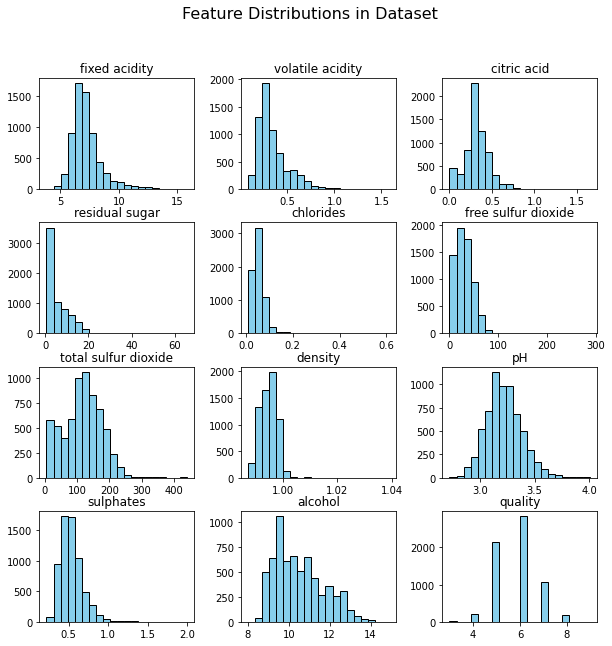

In [55]:
# Visualize the distribution of the data
data.hist(bins=20, figsize=(10, 10), color='skyblue', edgecolor='black', grid=False)
plt.suptitle("Feature Distributions in Dataset", fontsize=16)
plt.show()

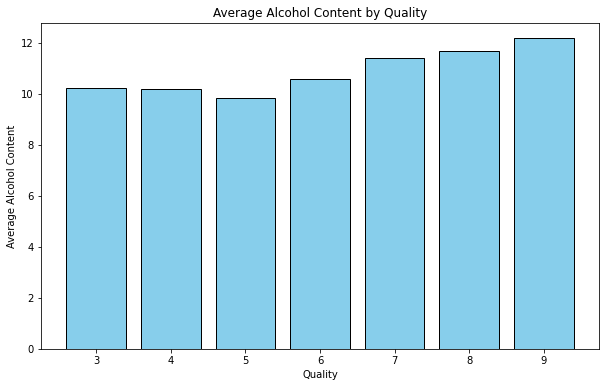

In [56]:
# Visualize relationship between quality and average alcohol content
plt.figure(figsize=(10, 6))

avg_alcohol = data.groupby('quality')['alcohol'].mean()
plt.bar(avg_alcohol.index, avg_alcohol.values, color='skyblue', edgecolor='black')
plt.xlabel('Quality')
plt.ylabel('Average Alcohol Content')
plt.title('Average Alcohol Content by Quality')
plt.show()

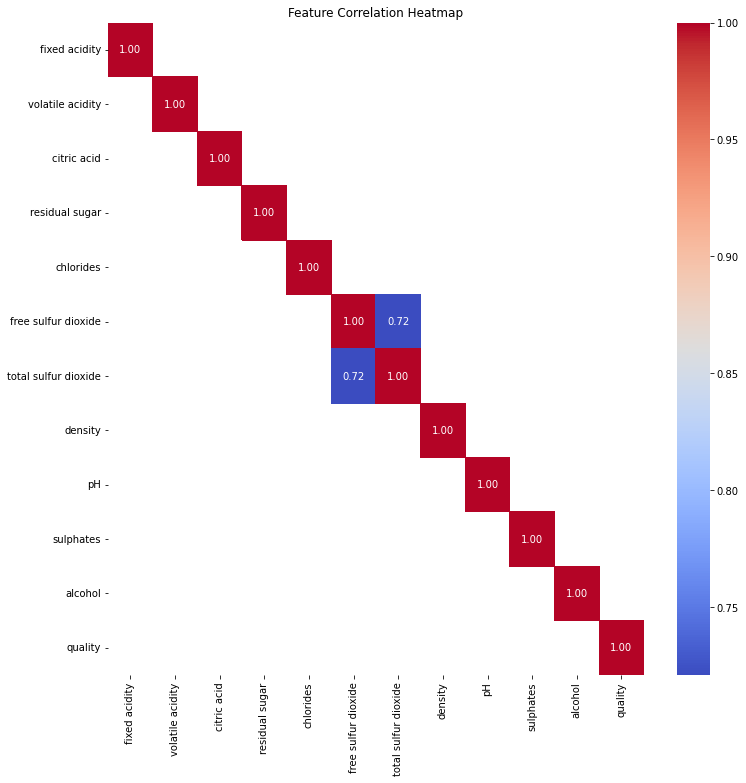

In [57]:
# Heatmap for |correlations| > 0.7
plt.figure(figsize=(12, 12))
correlation_matrix = data.corr()
mask = (correlation_matrix < 0.7) & (correlation_matrix > -0.7)
sb.heatmap(correlation_matrix, annot=True, fmt=".2f", mask=mask, cmap="coolwarm", cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()

In [58]:
# Drop highly correlated column: 'total sulfur dioxide' and 'free sulphur dioxide' columns
data = data.drop('total sulfur dioxide', axis=1)
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,0.9956,3.19,0.40,9.9,6


In [59]:
# Feature Engineering: Create a binary target variable to predict not the exact quality, but if the quality is high (i.e. over 5)
data['best quality'] = [1 if x > 5 else 0 for x in data.quality]  
# Convert type column to ones and zeros
data.replace({'white': 1, 'red': 0}, inplace=True)

(4) Extract the features and the label, and split the data

In [60]:
# Separate features and labels
features = data.drop(['quality', 'best quality'], axis=1)
label = data['best quality']

xtrain, xtest, ytrain, ytest = train_test_split(features, label, test_size=0.2, random_state=40)

(5) Normalize the data using Min-Max normalization

In [61]:
norm = MinMaxScaler()
xtrain = norm.fit_transform(xtrain)
xtest = norm.transform(xtest)

(6) Train the models: Logistic regression, XGBoost and SVM

In [62]:
# Initialize models
models = [
    LogisticRegression(random_state = 0),
    LogisticRegression(penalty='l1', solver='liblinear', random_state=0, max_iter=1000),
    LogisticRegression(penalty='l2', solver='lbfgs', random_state=0),
    GaussianNB(),
    SVC(kernel = 'linear', random_state = 0),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(random_state=0),
    KNeighborsClassifier(),
    GradientBoostingClassifier(random_state=0),
    LGBMClassifier(),
    AdaBoostClassifier(random_state=0),
    XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    MLPClassifier(max_iter=2000, random_state=0),
    LinearDiscriminantAnalysis()
    ]

# Train models and evaluate using ROC-AUC score
for model in models:
    model.fit(xtrain, ytrain)
    ytrain_pred = model.predict(xtrain)
    ytest_pred = model.predict(xtest)

    print(f'{model.__class__.__name__}:')
    print('Training ROC-AUC Score: ', metrics.roc_auc_score(ytrain, ytrain_pred))
    print('Validation ROC-AUC Score: ', metrics.roc_auc_score(ytest, ytest_pred))
    print('-'*25)

LogisticRegression:
Training ROC-AUC Score:  0.7019709565048414
Validation ROC-AUC Score:  0.6937888865050418
-------------------------
LogisticRegression:
Training ROC-AUC Score:  0.7045887575519619
Validation ROC-AUC Score:  0.7022455839233355
-------------------------
LogisticRegression:
Training ROC-AUC Score:  0.7019709565048414
Validation ROC-AUC Score:  0.6937888865050418
-------------------------
GaussianNB:
Training ROC-AUC Score:  0.6396780431240314
Validation ROC-AUC Score:  0.6251340913966961
-------------------------
SVC:
Training ROC-AUC Score:  0.6991656008040561
Validation ROC-AUC Score:  0.6879450557309386
-------------------------
DecisionTreeClassifier:
Training ROC-AUC Score:  1.0
Validation ROC-AUC Score:  0.7586686895311655
-------------------------
RandomForestClassifier:
Training ROC-AUC Score:  1.0
Validation ROC-AUC Score:  0.8112784912291455
-------------------------
KNeighborsClassifier:
Training ROC-AUC Score:  0.813513890194117
Validation ROC-AUC Score:  0

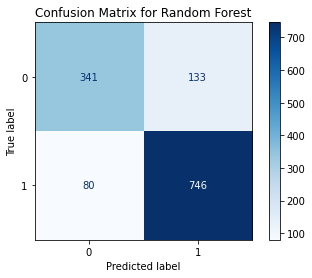

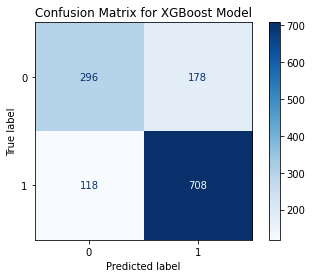

In [63]:
# Confusion Matrix for XGBoost
cm = confusion_matrix(ytest, models[6].predict(xtest))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]) 

disp.plot(cmap="Blues")  
plt.title("Confusion Matrix for Random Forest")
plt.show()

# Confusion Matrix for XGBoost
cm = confusion_matrix(ytest, models[12].predict(xtest))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]) 

disp.plot(cmap="Blues")  
plt.title("Confusion Matrix for XGBoost Model")
plt.show()

RandomForest and XGBoost predict mostly accurate. Random Forest has correctly predicted 746 "best quality" (i.e 1) labels and 341 "not best quality" (i.e. 0) labels, while XGBoost has correctly predicted 708 "best quality" (i.e 1) labels and 296 "not best quality" (i.e. 0) labels.

In [65]:
# Classification report for Random Forest
print("Classification Report for Random Forest:\n", classification_report(ytest, models[6].predict(xtest)))

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.81      0.72      0.76       474
           1       0.85      0.90      0.88       826

    accuracy                           0.84      1300
   macro avg       0.83      0.81      0.82      1300
weighted avg       0.83      0.84      0.83      1300



Summary:
* 81% of samples predicted as class 0 were correct
* 85% of samples predicted as class 1 were correct
* 72% of all actual class 0 samples are correcty identified.
* 90% of all actual class 1 samples are correcty identified.
* **Support** column: Number of true instances (not predicted) for each class.

In [66]:
# Classification report for XGBoost
print("Classification Report for XGBoost:\n", classification_report(ytest, models[12].predict(xtest)))

Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.71      0.62      0.67       474
           1       0.80      0.86      0.83       826

    accuracy                           0.77      1300
   macro avg       0.76      0.74      0.75      1300
weighted avg       0.77      0.77      0.77      1300



Summary:
* 71% of samples predicted as class 0 were correct
* 80% of samples predicted as class 1 were correct
* 62% of all actual class 0 samples are correcty identified.
* 86% of all actual class 1 samples are correcty identified.

#### **Analysis**

Both Random Forest and XGBoost are ensemble models made up of decision trees, which allows them to understand feature importance and interactions between features.